<a href="https://colab.research.google.com/github/kelzla/llm-notebooks/blob/main/Ludwig_Fine_Tune_Llama_2_13b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ludwig: Efficient Fine-Tuning for Llama-2-13b on a Single GPU** 🙌

Let's explore how to fine-tune an LLM on a single commodity GPU with [Ludwig](https://ludwig.ai/latest/), an open-source package that empowers you to effortlessly build and train machine learning models like LLMs, neural networks and tree based models through declarative config files.

In this notebook, we'll show an example of how to fine-tune Llama-2-13b to generate code using the CodeAlpaca dataset.

By the end of this example, you will have gained a comprehensive understanding of the following key aspects:

1. **Ludwig**: An intuitive toolkit that simplifies fine-tuning for open-source Language Model Models (LLMs).
2. **Exploring the base model with prompts**: Dive into the intricacies of prompts and prompt templates, unlocking new dimensions in LLM interaction.
3. **Fine-Tuning Large Language Models**: Navigate the world of model fine-tuning optimizations for getting the most out of a single memory-contrained GPU, including: LoRA and 4-bit quantization.

<br>

👀 If you're interested in a managed solution for training larger LLMs that require distributed training using multi-node multi-GPU setups, or for fast on-demand inference for LLMs, check out [Predibase](https://predibase.com/), the AI platform for engineers built on top of Ludwig! Try Predibase's free 14 day trial by signing up [here](https://pbase.ai/3OD77wQ).

# **Goal: Use LLMs For Code-Generation** 💻

In this webinar, the goal is to use an LLM for code generation. The model will take natural language as input, and should return code as output. We're first going to iterate on a base Llama-2-13b model with prompting, and finally instruction-fine-tune the model.

As an example, if we prompt the model with this instruction:

```
Instruction: Create an array of length 5 which contains all even numbers between 1 and 10.
```

We want the model to produce exactly this response:

```
Response: array = [2, 4, 6, 8, 10]
```



# **A Quick 2 Minute Introduction To Ludwig** ⏰

Every Ludwig model is based on a config, which requires at least input feature and one output feature to be defined. For example,

```yaml
input_features:
  - name: instruction
    type: text
output_features:
  - name: output
    type: text
```

is a simple Ludwig config that tells Ludwig to use the column called `instruction` in our dataset as an input feature and the `output` column in our dataset as an `output` feature. This is the simplest Ludwig config we can define - it's just 6 lines and works out of the box!

To make Ludwig compatible with LLMs, **Ludwig 0.8** introduced a new `model_type` called `llm` and a new keyword `base_model` that must be specified:

```yaml
model_type: llm
base_model: meta-llama/Llama-2-13b-hf
input_features:
  - name: instruction
    type: text
output_features:
  - name: output
    type: text
```

The `model_type` parameter indicated is used to tell Ludwig you want to use the LLM model type (Ludwig supports LLMs, general deep neural networks and trees).
The `base_model` parameter is the path to any HuggingFace CausalLM listed [here](https://huggingface.co/models?pipeline_tag=text-generation&sort=trending).

Once you define your YAML Config, there are two ways you can use it with Ludwig:

- Through the Python LudwigModel API: https://ludwig.ai/latest/user_guide/api/LudwigModel/
- Through the Ludwig CLI: https://ludwig.ai/latest/user_guide/command_line_interface/

For this webinar, we're going to make use of the Python LudwigModel API. This requires just one main object during initialization: a YAML config defining your training pipeline. The initialized LudwigModel object then exposes a variety of methods like `preprocess()`, `train()`, `evaluate()` and `predict()`. We will see this in practice in the next few sections.

In general, there is feature parity across both methods so you can use the approach you're most comfortable with. To see what commands are available, create a new cell and run `!ludwig --help`.

This is all you need for now! Keeping this in mind, let's dive into the latest features in Ludwig 0.8.

## **Basic Setup** 🧰

We're going to install Ludwig, setup our HuggingFace Token and load our dataset that we will be running experiments with.

### **Install Ludwig and Ludwig's LLM related dependencies.**

Install Ludwig from the latest release

In [ ]:
!pip uninstall -y tensorflow --quiet
!pip install ludwig --quiet
!pip install ludwig[llm] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 108.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 11.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━

Enable text wrapping so we don't have to scroll horizontally and create a function to flush CUDA cache.

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)

def clear_cache():
  if torch.cuda.is_available():
    torch.cuda.empty_cache()

### **Setup Your HuggingFace Token** 🤗

We'll be exploring Llama-2 today, which a model released by Meta. However, the model is not openly-accessible and requires requesting for access (assigned to your HuggingFace token).

Obtain a [HuggingFace API Token](https://huggingface.co/settings/tokens) and request access to [Llama2-13b-hf](https://huggingface.co/meta-llama/Llama-2-13b-hf) before proceeding. You may need to signup on HuggingFace if you don't aleady have an account: https://huggingface.co/join

Incase you haven't been given access to Llama-2-13b, that is alright. We can just use Llama-1 for the rest of this example: [huggyllama/llama-13b](https://huggingface.co/huggyllama/llama-13b).

In [ ]:
import getpass
import locale; locale.getpreferredencoding = lambda: "UTF-8"
import logging
import os
import torch
import yaml

from ludwig.api import LudwigModel


os.environ["HUGGING_FACE_HUB_TOKEN"] = getpass.getpass("Token:")
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

Token:··········


### **Import The Code Generation Dataset** 📋



In [ ]:
from google.colab import data_table; data_table.enable_dataframe_formatter()
import numpy as np; np.random.seed(123)
import pandas as pd

df = pd.read_json("https://raw.githubusercontent.com/sahil280114/codealpaca/master/data/code_alpaca_20k.json")

# We're going to create a new column called `split` where:
# 90% will be assigned a value of 0 -> train set
# 5% will be assigned a value of 1 -> validation set
# 5% will be assigned a value of 2 -> test set
# Calculate the number of rows for each split value
total_rows = len(df)
split_0_count = int(total_rows * 0.9)
split_1_count = int(total_rows * 0.05)
split_2_count = total_rows - split_0_count - split_1_count

# Create an array with split values based on the counts
split_values = np.concatenate([
    np.zeros(split_0_count),
    np.ones(split_1_count),
    np.full(split_2_count, 2)
])

# Shuffle the array to ensure randomness
np.random.shuffle(split_values)

# Add the 'split' column to the DataFrame
df['split'] = split_values
df['split'] = df['split'].astype(int)

# For this webinar, we will just 500 rows of this dataset.
df = df.head(n=1000)

## **Understanding The Code Alpaca Dataset** 📖




In [ ]:
df.head(10)

,instruction,input,output,split
0,Create an array of length 5 which contains all...,,"arr = [2, 4, 6, 8, 10]",0
1,Formulate an equation to calculate the height ...,,Height of triangle = opposite side length * si...,0
2,Write a replace method for a string class whic...,"string = ""Hello World!""\nreplace_with = ""Greet...","def replace(self, replace_with):\n new_stri...",0
3,Create an array of length 15 containing number...,,"arr = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33...",0
4,Write a function to find the number of distinc...,"matrix = [[1, 0, 0],\n [1, 0, 1],\n ...",def find_num_distinct_states(matrix):\n sta...,0
5,Create a nested loop to print every combinatio...,,for i in range(10):\n for j in range(10):\n...,0
6,Write a function to find the maximum differenc...,"arr = [5, 3, 17, 11, 9]",def max_difference(arr):\n max_diff = 0\n ...,0
7,Write a function to generate the nth Fibonacci...,< noinput >,def fib(n):\n if n == 0:\n return 0\...,0
8,Write a class to represent a 2D point with x a...,,"class Point:\n def __init__(self, x, y):\n ...",0
9,Write code that removes spaces from a given st...,"string = "" A B C D ""","def remove_spaces(string): \n return """".joi...",0


This dataset is meant to train a large language model to following instructions to produce code from natural language. Each row in the dataset consists of an:
- `instruction` that describes a task
- `input` when additional context is required for the instruction, and
- the expected `output`.

There are two types of instructions:

#### **Type 1: Self-Sufficient**
Instructions that are self-sufficient and require no additional context.
```
Instruction: "Create an array of length 5 which contains all even numbers between 1 and 10."
Input: None (instruction is self-sufficient)
Output: "arr = [2, 4, 6, 8, 10]"
```

These examples are useful for training models to understand and follow instructions independently. They can be applied in various scenarios, including:

- **Coding Tasks**: Teaching a model to generate code based on a clear instruction. For instance, generating a function to sort an array in a specific way.
- **Mathematical Calculations**: Instructing a model to perform calculations or equations, such as finding the area of a shape given its dimensions.
- **Data Manipulation**: Showing how to process data, like filtering, transforming, or aggregating data based on given criteria.
- **Writing Instructions**: Training models to generate instructional content, like recipes, guides, or tutorials.

#### **Type 2: Need Context**
The instruction needs additional context provided in the `input` to complete the task.
```
Instruction: "Write a replace method for a string class which replaces the given string with a given set of characters."
Input: "string = 'Hello World!' replace_with = 'Greetings!'"
Output:
def replace(string, replace_with):
    new_string = ""
    for char in string:
        if char == " ":
            new_string += replace_with
        else:
            new_string += char
    return new_string
```

These examples are useful for training models to understand both the instruction and relevant context provided by the input. They find application in scenarios such as:

- **Customized Code Generation**: Teaching a model to generate code that depends on specific inputs. For instance, creating a function to calculate a mathematical result given input parameters.
- **Conditional Responses**: Guiding models to produce outputs that change based on different input conditions (think of a instruction that has different criteria for different letter grades, and then a conditional input like score = 85/100)
- **Dynamic Content Creation**: Training models to generate content based on variable input, such as dynamic forms, letters, or responses to user queries.
- **Configurable Processes**: Demonstrating how to perform tasks with customizable settings, like configuring a software component using provided parameters.


As you can see below, the dataset is pretty balanced in terms of the number of examples of each type of instruction (also true for the full dataset with 20,000 rows).

In [ ]:
num_self_sufficient = (df['input'] == '').sum()
num_need_context = df.shape[0] - num_self_sufficient

# We are only using 100 rows of this dataset for this webinar
print(f"Total number of examples in the dataset: {df.shape[0]}")

print(f"% of examples that are self-sufficient: {round(num_self_sufficient/df.shape[0] * 100, 2)}")
print(f"% of examples that are need additional context: {round(num_need_context/df.shape[0] * 100, 2)}")

Total number of examples in the dataset: 1000
% of examples that are self-sufficient: 47.2
% of examples that are need additional context: 52.8


The other aspect worth noting is the average number of characters in each of the three columns `instruction`, `input` and `output` in the dataset. Typically, every 3-4 characters maps to a *token* (the basic building blocks that language models use to understand and analyze text data), and large language models have a limit on the number of tokens they can take as input.

The maximum context length for the base LLaMA-2 model is 4096 tokens. Ludwig automatically truncates texts that are too long for the model, but looking at these sequence lengths, we should be able to fine-tune on full length examples without needing any truncation.





In [ ]:
from transformers import AutoTokenizer
import numpy as np

def calculate_distribution(data_dict):
    result = {}

    for key, values in data_dict.items():
        values = np.array(values)
        result[key] = {
            'average': int(np.mean(values)),
            'min': np.min(values),
            'max': np.max(values),
            'median': np.median(values),
            '75th_percentile': int(np.percentile(values, 75)),
            '90th_percentile': int(np.percentile(values, 90)),
            '95th_percentile': int(np.percentile(values, 95)),
            '99th_percentile': int(np.percentile(values, 99))
        }

    return result

tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-2-13b-hf')

token_counts = {
    "instruction": [],
    "input": [],
    "output": [],
    "total": []
}

for index, row in df.iterrows():
    instruction_col_tokens = len(tokenizer.tokenize(row['instruction']))
    input_col_tokens = len(tokenizer.tokenize(row['input']))
    output_col_tokens = len(tokenizer.tokenize(row['output']))
    total = instruction_col_tokens + input_col_tokens + output_col_tokens

    token_counts['instruction'].append(instruction_col_tokens)
    token_counts['input'].append(input_col_tokens)
    token_counts['output'].append(output_col_tokens)
    token_counts['total'].append(total)

token_distribution = calculate_distribution(token_counts)
token_distribution = pd.DataFrame(token_distribution)
token_distribution

,instruction,input,output,total
average,15.0,10.0,66.0,92.0
min,5.0,0.0,1.0,12.0
max,40.0,159.0,581.0,597.0
median,14.0,5.0,51.0,76.0
75th_percentile,17.0,17.0,93.0,121.0
90th_percentile,21.0,29.0,142.0,169.0
95th_percentile,23.0,41.0,180.0,208.0
99th_percentile,28.0,65.0,276.0,305.0


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['instruction'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_1, *['input'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_2, *['output'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_3, *['total'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_4, *['instruction'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_5, *['input'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_6, *['output'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_7, *['total'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_8, *['index'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_9, *[[['instruction', 'input'], ['input', 'output'], ['output', 'total']]], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_10, *['instruction', 'index'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_11, *['input', 'index'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_12, *['output', 'index'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_13, *['total', 'index'], **{'inner': 'stick'})
chart

# **Declaratively Fine-Tune Large Language Models**

Fine-tuning a large language model **refers to the process of further training the pre-trained model on a specific task or domain using a smaller dataset.** The initial pre-training phase involves training a language model on a massive corpus of text data to learn general language patterns and representations. Fine-tuning, on the other hand, customizes the model to a specific task or domain by exposing it to task-specific data. By fine-tuning a large language model on a specific task, you leverage the pre-trained knowledge of the model while tailoring it to the nuances and requirements of your target task. This typically allows the model to perform better and achieve higher accuracy on the specific task compared to using the pretrained model by itself for your specific task.

#### ▶ **What is instruction following/tuning? Why should I do it?**

Pre-trained language models are often great at giving general answers, but they struggle when asked to follow specific instructions, especially for tasks in certain domains. To make a pre-trained model do better at these specific tasks, we can train it on examples of those tasks. This is called instruction fine-tuning. We use a dataset with pairs of `{instructions, outputs}` in the domain, and this helps the model learn to give the right response when given those types of instructions. This training process typically changes the underlying model weights, but there are also other ways to train it without doing this. When done correctly, this process teaches the model to understand and follow instructions it couldn't handle well before.

#### ▶ **What will this teach the model?**

Here's an example of prompting the base model and an example prompting the fine-tuned model. The model was given all of the text until `Response:`, and it was supposed to continue generating an appropriate response.

**Using the base model (no fine-tuning):** 👎
```
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: create an array of length 5 which contains all even numbers between 1 and 10.

### Response:\n\n### Instruction: create an array of length 5 which contains all even numbers between 1 and 10.\n\n### Input: \n\n### Response:\n\n### Instruction: create an array of length 5 which contains all even numbers between 1 and 10.\n\n### Input: \n\n### Response:\n\n### Instruction: create an array of length 5 which contains all even numbers between 1 and 10.\n\n### Input: \n\n### Response:\n\n### Instruction: create an
```

**After instruction-fine-tuning:** 👍
```
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: create an array of length 5 which contains all even numbers between 1 and 10.

### Response: array = [2, 4, 6, 8, 10]
```

The base model does not know how to follow-instructions and answer the question for our task, so just repeats the inputs we passed in until the token limit is hit. Our fine-tuned model should be able to respond back correctly (these are actual outputs from a model we fine-tuned).


There are three different fine-tuning approaches in Ludwig:

1. **Full Fine-Tuning**:

- Involves training the entire pre-trained model on new data from scratch.
- All model layers and parameters are updated during fine-tuning.
- Can lead to high accuracy but requires a significant amount of computational resources and time.
- Runs the risk of catastrophic forgetting: occasionally, since we are updating all of the weights in the model, this process can lead to the algorithm inadvertently losing knowledge of its past tasks, i.e., the knowledge it gained during pretraining. The outcome may vary, with the algorithm experiencing heightened error margins in some cases, while in others, it might completely erase the memory of a specific task leading to terrible performance.
- Best suited when the target task is significantly different from the original pre-training task.

2. **Parameter Efficient Fine-Tuning (PEFT), e.g. LoRA**:

- Focuses on updating only a subset of the model's parameters.
- Often involves freezing certain layers or parts of the model to avoid catastrophic forgetting, or inserting additional layers that are trainable while keeping the original model's weights frozen.
- Can result in faster fine-tuning with fewer computational resources, but might sacrifice some accuracy compared to full fine-tuning.
- Includes methods like LoRA, AdaLoRA and Adaption Prompt (LLaMA Adapter)
- Suitable when the new task shares similarities with the original pre-training task.

3. **Quantization-Based Fine-Tuning (QLoRA)**:

- Involves reducing the precision of model parameters (e.g., converting 32-bit floating-point values to 8-bit or 4-bit integers). This reduces the amount of CPU and GPU memory required by either 4x if using 8-bit integers, or 8x if using 4-bit integers.
- Typically, since we're changing the weights to 8 or 4 bit integers, we will lose some precision/performance.
- This can lead to reduced memory usage and faster inference on hardware with reduced precision support.
- Particularly useful when deploying models on resource-constrained devices, such as mobile phones or edge devices.


**Today, we're going to fine-tune using method 3 since we only have access to a single T4 GPU with 16GiB of GPU VRAM on Colab.** If you have more compute available, give LoRA based fine-tuning or full fine-tuning a try! Typically this requires 4 GPUs with 24GiB of GPU VRAM on a single node multi-GPU cluster and fine-tuning Deepspeeed.


To do this, the new parameters we're introducing are:

- `adapter`: The PEFT method we want to use
- `quantization`: Load the weights in int4 or int8 to reduce memory overhead.
- `trainer`: We enable the `finetune` trainer and can configure a variety of training parameters such as epochs and learning rate.

Note, there are a few additional preprocessing parameters we should set to ensure that training runs smoothly:

```yaml
preprocessing:
  global_max_sequence_length: 512
  split:
    type: random
    probabilities:
    - 0.9
    - 0.05
    - 0.05
```

Some of the examples in the dataset have long sequences, so we set a `global_max_sequence_length` of 512 to ensure that we do not OOM.

We also use 100% of data for training as the evaluation phase takes extra time and we will predict on new examples right afterwards.

In [ ]:
qlora_fine_tuning_config = yaml.safe_load(
"""
model_type: llm
base_model: meta-llama/Llama-2-13b-hf

input_features:
  - name: instruction
    type: text

output_features:
  - name: output
    type: text

prompt:
  template: >-
    Below is an instruction that describes a task, paired with an input
    that provides further context. Write a response that appropriately
    completes the request.

    ### Instruction: {instruction}

    ### Input: {input}

    ### Response:

generation:
  temperature: 0.1
  max_new_tokens: 512

adapter:
  type: lora

quantization:
  bits: 4

preprocessing:
  global_max_sequence_length: 512
  split:
    type: random
    probabilities:
    - 0.9
    - 0.05
    - 0.05

trainer:
  type: finetune
  epochs: 1
  batch_size: 1
  eval_batch_size: 2
  gradient_accumulation_steps: 16
  learning_rate: 0.0004
  enable_gradient_checkpointing: true
  learning_rate_scheduler:
    warmup_fraction: 0.03
"""
)

model = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)
results = model.train(dataset=df)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-13b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'None': 220 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 222 (including start and stop symbols)
INFO:ludwig.features.text_feature:max sequence length is 222 for feature 'None'
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-13b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'output': 580 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 582 (including start and stop symbols)
INFO:ludwig.feat

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Done.
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-13b-hf tokenizer
INFO:ludwig.models.llm:==================================================
INFO:ludwig.models.llm:Trainable Parameter Summary For Fine-Tuning
INFO:ludwig.models.llm:Fine-tuning with adapter: lora
INFO:ludwig.models.llm:==================================================
INFO:ludwig.trainers.trainer:Gradient checkpointing enabled for training.
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:


trainable params: 6,553,600 || all params: 13,022,417,920 || trainable%: 0.05032552357220002


INFO:ludwig.trainers.trainer:Creating fresh model training run.
INFO:ludwig.trainers.trainer:Training for 900 step(s), approximately 1 epoch(s).
INFO:ludwig.trainers.trainer:Early stopping policy: 5 round(s) of evaluation, or 4500 step(s), approximately 5 epoch(s).

INFO:ludwig.trainers.trainer:Starting with step 0, epoch: 0


Training:   0%|          | 0/900 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Training: 100%|██████████| 900/900 [26:49<00:00,  1.71s/it, loss=0.0495]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 900, epoch: 0


Evaluation test : 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

INFO:ludwig.trainers.trainer:Evaluation took 1m 3.6122s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.2026 │       0.2167 │     0.2101 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     1.3325 │       1.1401 │     1.1308 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.7534 │       1.9000 │     1.6173 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 15288.6045 │   17695.1367 │ 17191.9492 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31517.8027 │   31707.9473 │ 31764.1523 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.


Training: 100%|██████████| 900/900 [27:54<00:00,  1.86s/it, loss=0.0495]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒═════════════════╕
INFO:ludwig.utils.print_utils:│ TRAINING REPORT │
INFO:ludwig.utils.print_utils:╘═════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════════════════╤════════════════════╕
│ Validation feature           │ output             │
├──────────────────────────────┼────────────────────┤
│ Validation metric            │ loss               │
├──────────────────────────────┼────────────────────┤
│ Best model step              │ 900                │
├──────────────────────────────┼────────────────────┤
│ Best model epoch             │ 1                  │
├──────────────────────────────┼────────────────────┤
│ Best model's validation loss │ 1.8999754190444946 │
├──────────────────────────────┼────────────────────┤
│ Best model's test loss       │ 1.617287278175354  │
╘══════════════════════════════╧════════════════════╛
INFO:ludwig.api:
Finished: api_experiment_run
INFO:ludwig.api:Saved to

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ FINISHED │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:


#### Perform Inference

We can now use the model we fine-tuned above to make predictions on some test examples to see whether fine-tuning the large language model improve its ability to follow instructions/the tasks we're asking it to perform.

In [ ]:
test_examples = pd.DataFrame([
      {
            "instruction": "Create an array of length 5 which contains all even numbers between 1 and 10.",
            "input": ''
      },
      {
            "instruction": "Create an array of length 15 containing numbers divisible by 3 up to 45.",
            "input": "",
      },
      {
            "instruction": "Create a nested loop to print every combination of numbers between 0-9",
            "input": ""
      },
      {
            "instruction": "Generate a function that computes the sum of the numbers in a given list",
            "input": "",
      },
      {
            "instruction": "Create a class to store student names, ages and grades.",
            "input": "",
      },
      {
            "instruction": "Print out the values in the following dictionary.",
            "input": "my_dict = {\n  'name': 'John Doe',\n  'age': 32,\n  'city': 'New York'\n}",
      },
])

predictions = model.predict(test_examples)[0]
for input_with_prediction in zip(test_examples['instruction'], test_examples['input'], predictions['output_response']):
  print(f"Instruction: {input_with_prediction[0]}")
  print(f"Input: {input_with_prediction[1]}")
  print(f"Generated Output: {input_with_prediction[2][0]}")
  print("\n\n")

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-13b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "do_sample": true,
  "max_length": 32,
  "max_new_tokens": 512,
  "pad_token_id": 2,
  "temperature": 0.1
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that provides further context. write a response that appropriately completes the request.
### instruction: create an array of length 5 which contains all even numbers between 1 and 10.
### input: 
### response:
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: below is an instruction that describes a task, paired with an input that provides further context. write a response that appropriately completes the request.
### instruction: create an array of length 5 which contains all even numbers between 1 and 10.
### input: 
### response: const even_numbers = [2, 4, 6, 8, 10];
INFO:ludwig.models.llm:Decoded text inputs for the first example in

Prediction: 100%|██████████| 1/1 [00:28<00:00, 28.44s/it]


INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-13b-hf tokenizer


Instruction: Create an array of length 5 which contains all even numbers between 1 and 10.
Input: 
Generated Output: const even_numbers = [2, 4, 6, 8, 10];



Instruction: Create an array of length 15 containing numbers divisible by 3 up to 45.
Input: 
Generated Output: let divisible_by_3_array = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45];



Instruction: Create a nested loop to print every combination of numbers between 0-9
Input: 
Generated Output: for i in range(10):
    for j in range(10):
        print(i, j)



Instruction: Generate a function that computes the sum of the numbers in a given list
Input: 
Generated Output: def sum_list(lst):
    return sum(lst)



Instruction: Create a class to store student names, ages and grades.
Input: 
Generated Output: class student:
    def __init__(self, name, age, grade):
        self.name = name
        self.age = age
        self.grade = grade



Instruction: Print out the values in the following dictionary.
Input: my_dic

/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))


#### **Observations From QLoRA Fine-Tuning** 🔎
- Even when we just fine-tune the model on 1000 examples from our dataset (which only takes about 4 minutes), it significantly improves the model on our task 🔥
- The answers are not perfect when we just use 1000 examples, but if we inspect the *logic* in the response, we can see that it is 95% of the way there. This is SIGNIFICANTLY better than before - there is no repetition and the actual code aspects of the answers are all correct.
- The partial errors such as `sierp` instead of `arrray` etc indicate that we need to train on a larger amount of data for the model to better learn how to follow instructions and not make these kinds of mistakes.

If you're looking for a managed solution to handle all of the hassle of figuring out the right compute for your fine-tuning task, ensuring that they always succeed without CPU or GPU out-of-memory errors, and be able to rapidly deploy them for fast real-time inference, check out [Predibase](https://www.predibase.com/).

# **Upload Trained Model Artifacts To HuggingFace** 🤗

Now that we have a fine-tuned model, we can export the model weights to HuggingFace hub so we can use them in downstream tasks or in production. Ludwig supports uploading model weights directly to HuggingFace Hub via the `upload` Ludwig command.

```
!ludwig upload hf_hub --repo_id <hf_user_name>/<repo_name> --model_path <top_level_model_directory>
```

The `model-path` can be seen at the end of training/fine-tuning, as seen in this screenshot.

<br>

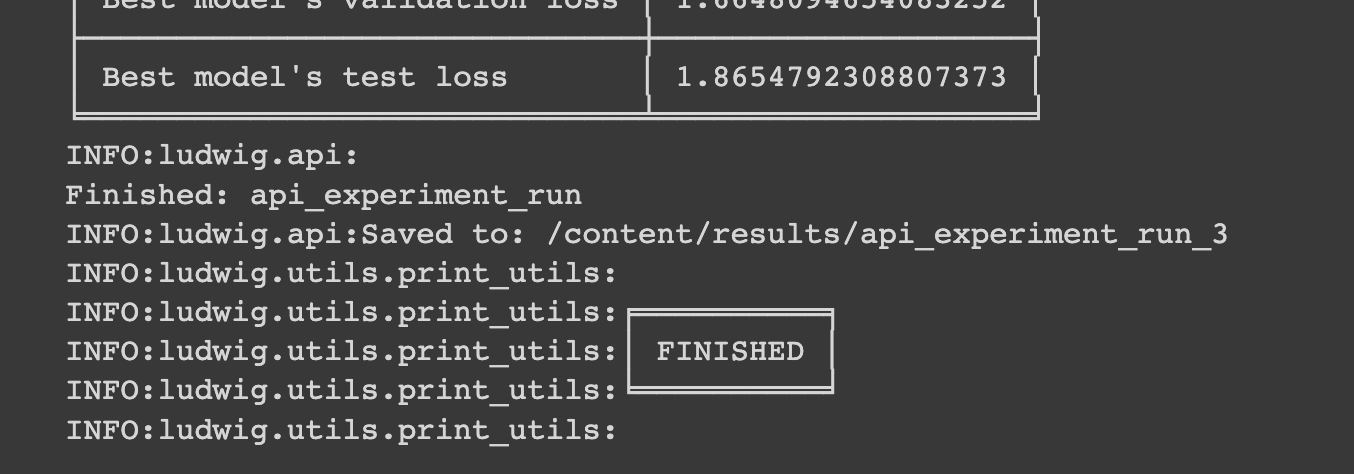

In [ ]:
!ludwig upload hf_hub --repo_id arnavgrg/ludwig-webinar --model_path /content/results/api_experiment_run_3


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-c

# **Resources** 🧺

- If you're new to LLMs, check out this webinar where Daliana Liu discusses the 10 things to know about LLMs: https://www.youtube.com/watch?v=fezMHMk7u5o&t=2027s&ab_channel=Predibase
- Ludwig 0.8 Release Blogpost for the full set of new features: https://predibase.com/blog/ludwig-v0-8-open-source-toolkit-to-build-and-fine-tune-custom-llms-on-your-data
- Ludwig Documentation: https://ludwig.ai/latest/

# **Try Predibase: The first low-code AI platform for developers**

If you're interested in a managed solution for training larger LLMs that require distributed training using multi-node multi-GPU setups, or for fast on-demand inference for LLMs, check out [Predibase](https://predibase.com/), the AI platform for engineers built on top of Ludwig! Try our free 14 day trial here by signing up [here](https://pbase.ai/3OD77wQ)

## How can Predibase help me with fine-tuning?
Here's a 6 minute read through of the challenges that fine-tuning poses, and how Predibase solves all of them for you. You can fine-tune Llama-2 with Scalable LLM infrastructure through Predibase: https://predibase.com/blog/how-to-fine-tune-llama-2-on-your-data-with-scalable-llm-infrastructure

### Check out these great blog posts and webinars on LLMs
1. Beyond Chat Use Cases for LLMs in Production: https://predibase.com/blog/beyond-chat-use-cases-for-llms-in-production
2. From Unstructured to Structured Data with Predibase: https://www.youtube.com/watch?v=KMZ_OSJ6bOE&t=523s&ab_channel=Predibase
3. Build your own LLM in less than 10 lines of code: https://www.youtube.com/watch?v=efMQgwM9dFY&ab_channel=Predibase